
=== Initial Environment State ===


/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

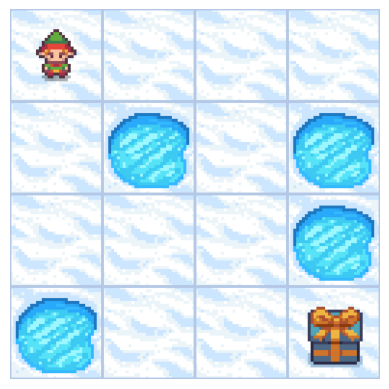


=== Executing Random Actions ===


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


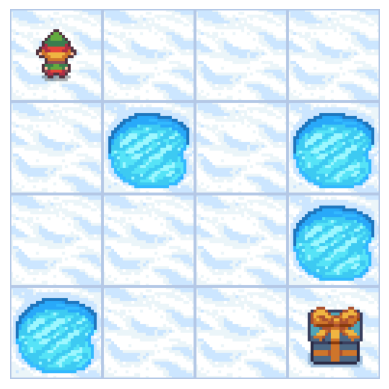

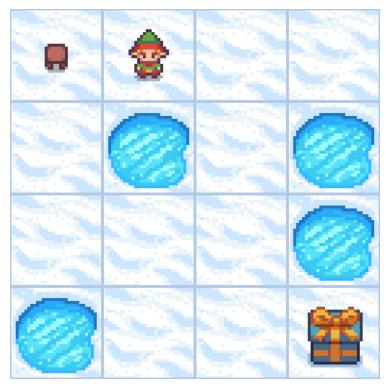

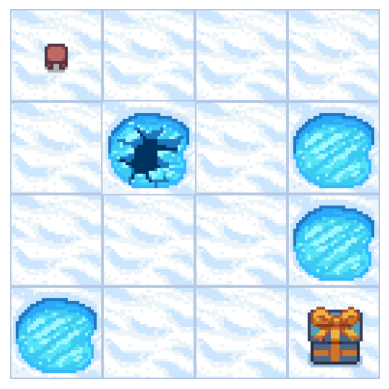


=== Value Iteration ===
Value-iteration converged at iteration# 1373.
Optimal Value Function:
[0.82352941 0.82352941 0.82352941 0.82352941 0.82352941 0.
 0.52941176 0.         0.82352941 0.82352941 0.76470588 0.
 0.         0.88235294 0.94117647 0.        ]
Optimal Policy:
[0. 3. 3. 3. 0. 0. 0. 0. 3. 1. 0. 0. 0. 2. 1. 0.]

=== Environment After Value Iteration ===


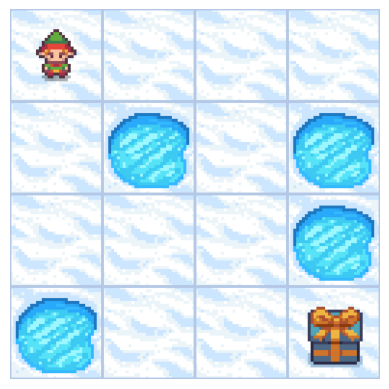


=== Policy Iteration ===
Policy-iteration converged at iteration# 7.
Optimal Policy:
[0. 3. 3. 3. 0. 0. 0. 0. 3. 1. 0. 0. 0. 2. 1. 0.]

=== Environment After Policy Iteration ===


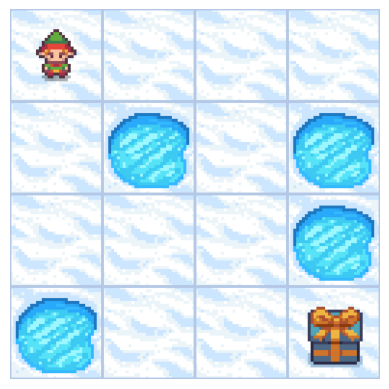


=== Executing Optimal Policy ===


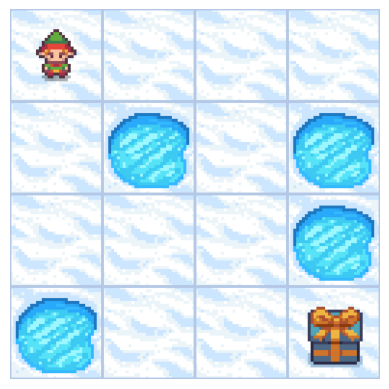

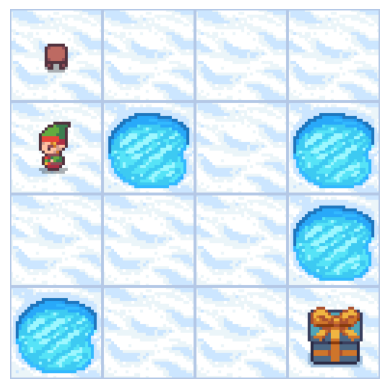

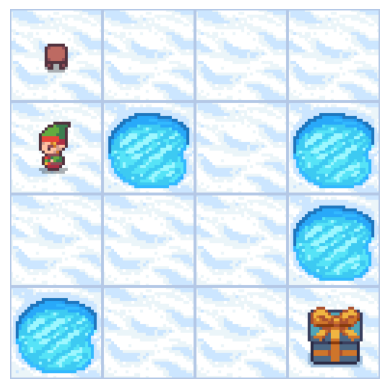

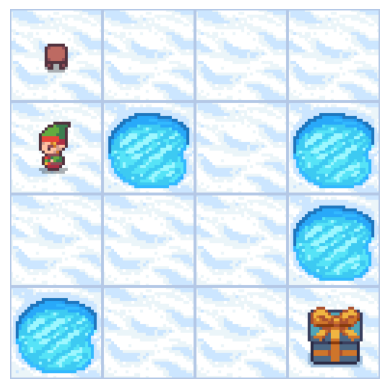

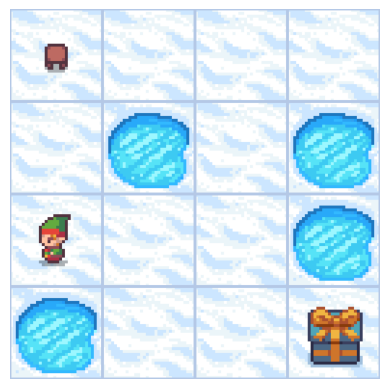

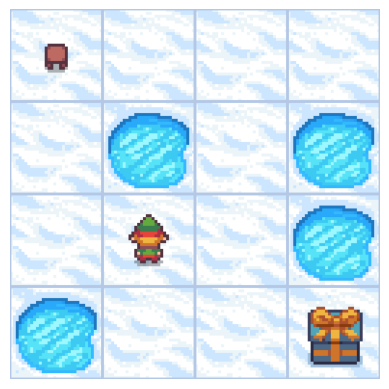

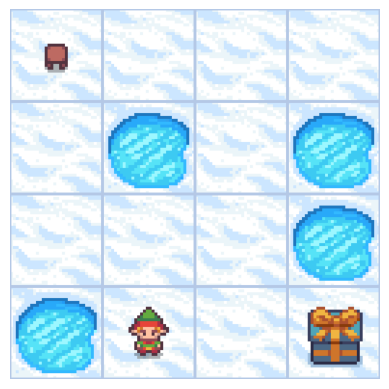

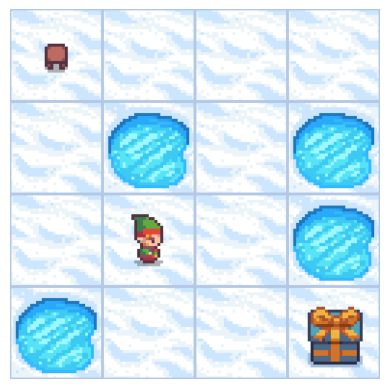

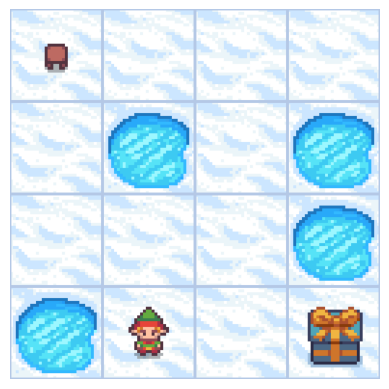

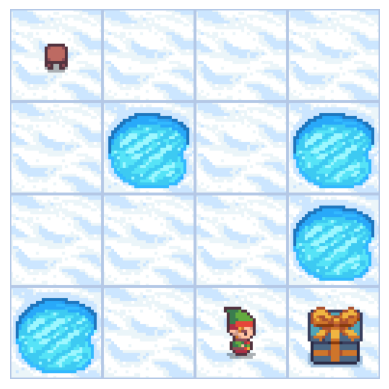

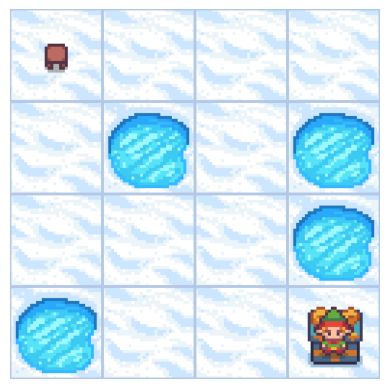

Game Over! Score: 1.0

=== Conclusions ===
1. Value Iteration converges faster to the optimal solution, especially for small environments.
2. Policy Iteration may be simpler to implement as it evaluates only policies, not the entire value function.
3. Both methods lead to the same optimal policies in discrete state problems like 'Frozen Lake'.


In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

def show_render(img):
    # Check if img is a list of images
    if isinstance(img, list):
        img = img[0]  # Select the first image from the list

    # Check the dimensions and format of the image
    if img.ndim == 4:
        img = img[0]  # If the image is a batch (array of multiple images), select the first one

    # Remove unnecessary dimensions
    img = np.squeeze(img)
    if img.ndim == 3 and img.shape[-1] == 3:  # If the image has RGB channels
        img = img[..., :3]  # Select only the first three channels (RGB)

    plt.imshow(img)
    plt.axis('off')  # Turn off the axes
    plt.show()

# Create the FrozenLake environment with the new API
env = gym.make(
    'FrozenLake-v1',
    desc=None,
    map_name="4x4",
    is_slippery=True,
    render_mode="rgb_array",
    new_step_api=True
)

# Function to choose random actions
def random_policy(env):
    return np.random.choice(env.action_space.n)

# Value Iteration function
def value_iteration(env, gamma=1.0):
    value_table = np.zeros(env.observation_space.n)
    no_of_iterations = 100000
    threshold = 1e-20

    for i in range(no_of_iterations):
        updated_value_table = np.copy(value_table)

        for state in range(env.observation_space.n):
            Q_value = []
            for action in range(env.action_space.n):
                next_states_rewards = []
                for next_sr in env.P[state][action]:
                    trans_prob, next_state, reward_prob, _ = next_sr
                    next_states_rewards.append((trans_prob * (reward_prob + gamma * updated_value_table[next_state])))

                Q_value.append(np.sum(next_states_rewards))

            value_table[state] = max(Q_value)

        if (np.sum(np.fabs(updated_value_table - value_table)) <= threshold):
            print(f'Value-iteration converged at iteration# {i + 1}.')
            break

    return value_table

# Function to extract policy from the value function
def extract_policy(value_table, gamma=1.0):
    policy = np.zeros(env.observation_space.n)

    for state in range(env.observation_space.n):
        Q_table = np.zeros(env.action_space.n)

        for action in range(env.action_space.n):
            for next_sr in env.P[state][action]:
                trans_prob, next_state, reward_prob, _ = next_sr
                Q_table[action] += (trans_prob * (reward_prob + gamma * value_table[next_state]))

        policy[state] = np.argmax(Q_table)

    return policy

# Policy Iteration function
def policy_iteration(env, gamma=1.0):
    def compute_value_function(policy, gamma):
        value_table = np.zeros(env.observation_space.n)
        threshold = 1e-10

        while True:
            updated_value_table = np.copy(value_table)

            for state in range(env.observation_space.n):
                action = policy[state]
                value_table[state] = sum([trans_prob * (reward_prob + gamma * updated_value_table[next_state])
                                          for trans_prob, next_state, reward_prob, _ in env.P[state][action]])

            if np.sum(np.fabs(updated_value_table - value_table)) <= threshold:
                break

        return value_table

    policy = np.zeros(env.observation_space.n)

    for i in range(100000):
        new_value_function = compute_value_function(policy, gamma)
        new_policy = extract_policy(new_value_function, gamma)

        if np.array_equal(policy, new_policy):
            print(f'Policy-iteration converged at iteration# {i + 1}.')
            break

        policy = new_policy

    return policy

# Function to execute the policy in the environment
def run_policy(env, policy):
    obs = env.reset()  # Initialize the environment, get only the state
    done = False
    total_reward = 0

    while not done:
        action = int(policy[obs])  # Select action from the policy based on the current state
        obs, reward, done, truncated, info = env.step(action)  # Execute the action
        total_reward += reward  # Add the reward

        img = env.render()  # Get the image
        show_render(img)  # Display the image

        if done:
            print(f"Game Over! Score: {total_reward}")
            break

# Visualize the initial state of the environment
print("\n=== Initial Environment State ===")
obs = env.reset()  # Initialize the environment and get the first state
start_img = env.render()  # Get the image
show_render(start_img)  # Display the image

# Execute a few steps with random actions
print("\n=== Executing Random Actions ===")
for _ in range(20):  # Execute 20 steps
    action = random_policy(env)  # Select a random action
    obs, reward, done, truncated, info = env.step(action)  # Execute the action
    img = env.render()  # Get the image
    show_render(img)  # Display the image
    if done:
        break  # End the game if it's over

# Perform value iteration
print("\n=== Value Iteration ===")
optimal_value_function = value_iteration(env=env, gamma=1.0)
optimal_policy_vi = extract_policy(optimal_value_function, gamma=1.0)
print("Optimal Value Function:")
print(optimal_value_function)
print("Optimal Policy:")
print(optimal_policy_vi)

# Visualize after value iteration
print("\n=== Environment After Value Iteration ===")
obs = env.reset()  # Reinitialize the environment
value_img = env.render()  # Get the image
show_render(value_img)  # Display the image

# Perform policy iteration
print("\n=== Policy Iteration ===")
optimal_policy_pi = policy_iteration(env=env, gamma=1.0)
print("Optimal Policy:")
print(optimal_policy_pi)

# Visualize after policy iteration
print("\n=== Environment After Policy Iteration ===")
obs = env.reset()  # Reinitialize the environment
policy_img = env.render()  # Get the image
show_render(policy_img)  # Display the image

# Execute the optimal policy
print("\n=== Executing Optimal Policy ===")
run_policy(env, optimal_policy_pi)

# Conclusions
print("\n=== Conclusions ===")
print("1. Value Iteration converges faster to the optimal solution, especially for small environments.")
print("2. Policy Iteration may be simpler to implement as it evaluates only policies, not the entire value function.")
print("3. Both methods lead to the same optimal policies in discrete state problems like 'Frozen Lake'.")
